In [1]:
# Imports
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def load_faces_from_dataset(dataset_path):
    # Store face images and labels
    images = []
    labels = []

    # Loop through each emotion folder
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue

        # Normalise label naming (e.g., "Happy" -> "happy")
        label = label.lower()

        # Loop through all images in the class folder
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)

            # Load image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Detect faces
            faces = face_cascade.detectMultiScale(
                img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
            )

            # Crop the largest detected face (if any)
            if len(faces) > 0:
                x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
                face = img[y:y+h, x:x+w]
            else:
                # If no face detected, use the full image
                face = img

            # Resize to standard size
            face = cv2.resize(face, (64, 64))

            # Store results
            images.append(face)
            labels.append(label)

    return images, labels

In [3]:
def extract_hog_features(images):
    # Store HOG feature vectors
    features = []

    for img in images:
        # Extract HOG features from a 64x64 grayscale face image
        hog_features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            feature_vector=True
        )
        features.append(hog_features)

    return np.array(features)

In [4]:
def run_experiment_train_test(train_path, test_path, dataset_name):
    print(f"\nRunning experiment on {dataset_name}")

    # Load faces and labels
    X_train_faces, y_train = load_faces_from_dataset(train_path)
    X_test_faces, y_test = load_faces_from_dataset(test_path)

    # Extract HOG features
    X_train = extract_hog_features(X_train_faces)
    X_test = extract_hog_features(X_test_faces)

    # Build model pipeline (scaling + SVM)
    model = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", C=7, gamma="scale", class_weight="balanced")
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)

    # Fix label order for consistent reporting
    labels_order = sorted(list(set(y_train) | set(y_test)))

    # Print classification report
    print("\nClassification Report:\n",
          classification_report(y_test, y_test_pred, labels=labels_order, zero_division=0))

    # Confusion matrix (same label order)
    cm = confusion_matrix(y_test, y_test_pred, labels=labels_order)

    # Capitalise labels for display only
    display_labels = [lab.capitalize() for lab in labels_order]

    # Plot confusion matrix
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    # Labels
    plt.xticks(range(len(display_labels)), display_labels)
    plt.yticks(range(len(display_labels)), display_labels)

    # Add numbers inside each cell
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black"
            )

    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return model, train_acc, test_acc


Running experiment on JAFFE (HOG + SVM)
Train Accuracy: 1.0
Test Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

       angry       0.82      1.00      0.90         9
        fear       0.53      1.00      0.69        10
       happy       1.00      0.67      0.80         9
     neutral       1.00      0.67      0.80         9
         sad       1.00      0.78      0.88         9
    surprise       1.00      0.67      0.80         9

    accuracy                           0.80        55
   macro avg       0.89      0.80      0.81        55
weighted avg       0.88      0.80      0.81        55



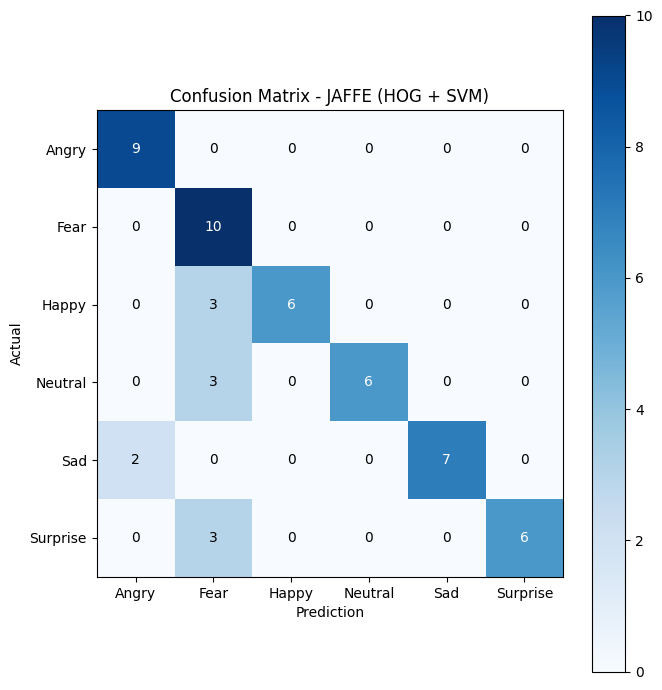

In [5]:
# Train and test on JAFFE
jaffe_model, jaffe_train_acc, jaffe_test_acc = run_experiment_train_test(
    "JAFFE/JAFFE-[70,30]/train",
    "JAFFE/JAFFE-[70,30]/test",
    "JAFFE (HOG + SVM)"
)


Running experiment on CK (HOG + SVM)
Train Accuracy: 1.0
Test Accuracy: 0.6153846153846154

Classification Report:
               precision    recall  f1-score   support

       anger       0.71      0.28      0.40        18
        fear       0.00      0.00      0.00         7
       happy       0.93      0.87      0.90        30
     neutral       0.41      0.72      0.53        36
     sadness       0.40      0.35      0.38        17
    surprise       0.83      0.71      0.77        35

    accuracy                           0.62       143
   macro avg       0.55      0.49      0.49       143
weighted avg       0.64      0.62      0.60       143



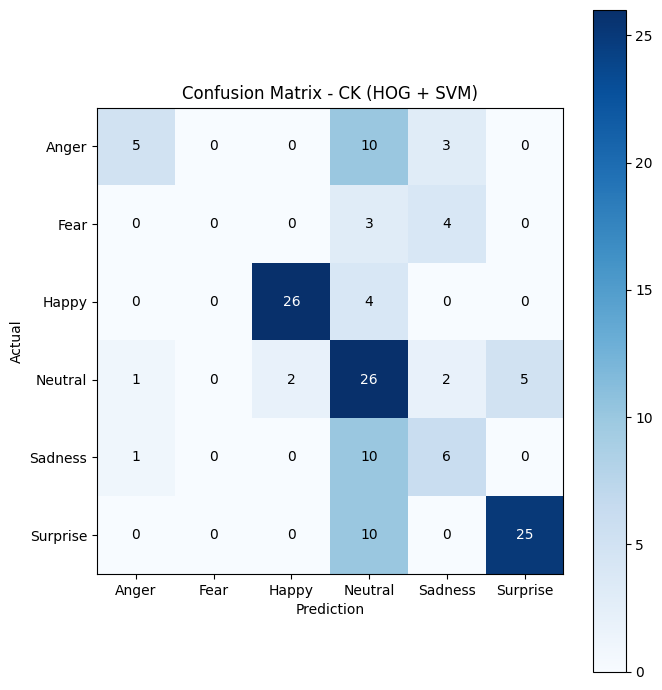

In [6]:
# Train and test on CK
ck_model, ck_train_acc, ck_test_acc = run_experiment_train_test(
    "CK/CK_dataset/train",
    "CK/CK_dataset/test",
    "CK (HOG + SVM)"
)

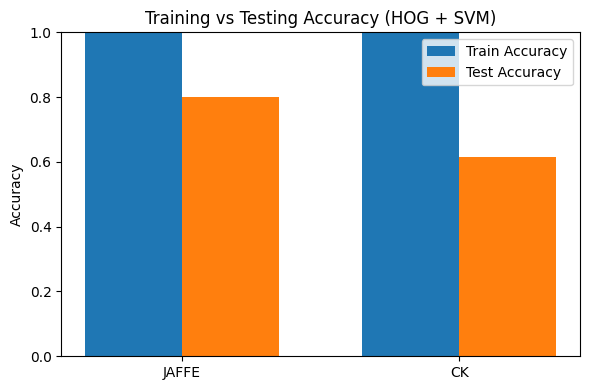

In [7]:
# Plot training vs testing accuracy
datasets = ["JAFFE", "CK"]
train_scores = [jaffe_train_acc, ck_train_acc]
test_scores  = [jaffe_test_acc, ck_test_acc]

x = range(len(datasets))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar([i - width/2 for i in x], train_scores, width, label="Train Accuracy")
plt.bar([i + width/2 for i in x], test_scores,  width, label="Test Accuracy")
plt.xticks(list(x), datasets)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy (HOG + SVM)")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def predict_single_image(image_path, model):
    # Load original image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
    )

    # Draw predictions on detected faces
    for (x, y, w, h) in faces:
        # Crop face region
        face = gray[y:y+h, x:x+w]

        # Histogram equalisation + resize (match training)
        face = cv2.equalizeHist(face)
        face = cv2.resize(face, (64, 64))

        # Extract features and predict
        features = extract_hog_features([face])
        prediction = model.predict(features)[0]

        # Draw rectangle and label
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(
            img, prediction, (x, y-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2
        )

    # Show result
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

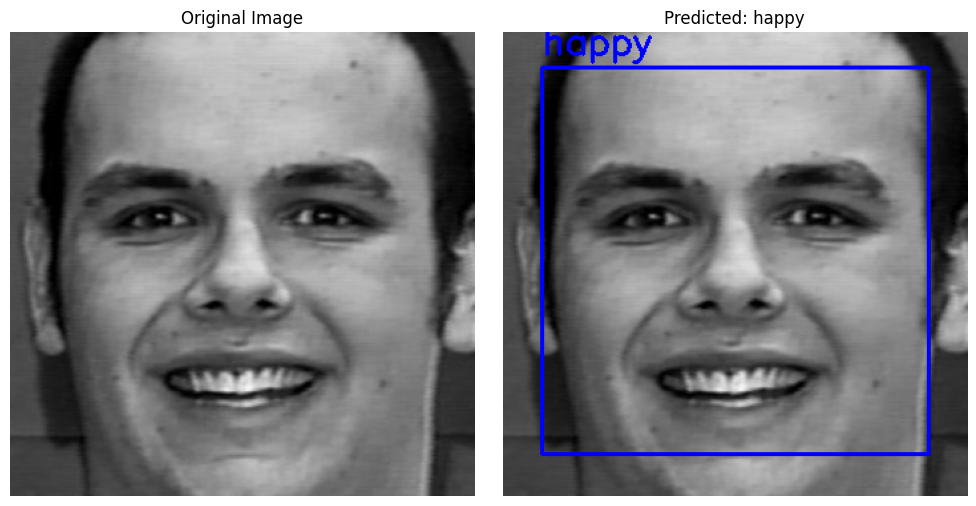

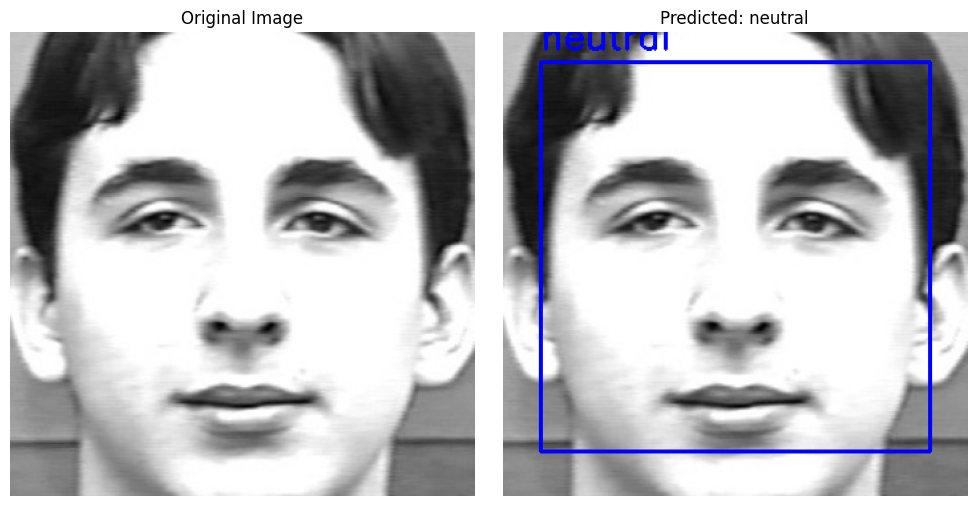

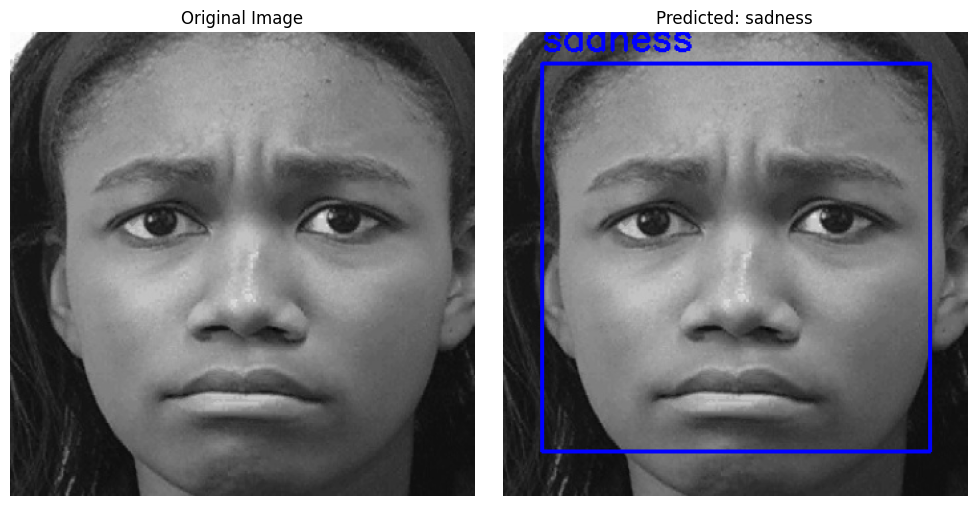

In [9]:
def show_original_and_prediction(image_path, model):
    # Load original image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Convert to RGB (for display) and grayscale (for detection)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
    )

    img_pred = img.copy()
    label = "No face detected"

    if len(faces) > 0:
        # Select the largest detected face (consistent with training)
        x, y, w, h = max(faces, key=lambda b: b[2] * b[3])

        # Crop face region
        face = gray[y:y+h, x:x+w]

        # Histogram equalisation + resize (match training)
        face = cv2.equalizeHist(face)
        face = cv2.resize(face, (64, 64))

        # Extract features and predict
        features = extract_hog_features([face])
        label = model.predict(features)[0]

        # Draw rectangle and predicted label
        cv2.rectangle(img_pred, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(
            img_pred, label, (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2
        )

    # Convert prediction image to RGB for display
    img_pred_rgb = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)

    # Plot original vs predicted side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(img_pred_rgb)
    axes[1].set_title(f"Predicted: {label}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    plt.close(fig)

# 3 examples
show_original_and_prediction("CK/CK_dataset/test/happy/6.jpg", ck_model)
show_original_and_prediction("CK/CK_dataset/test/neutral/2.jpg", ck_model)
show_original_and_prediction("CK/CK_dataset/test/sadness/7.jpg", ck_model)

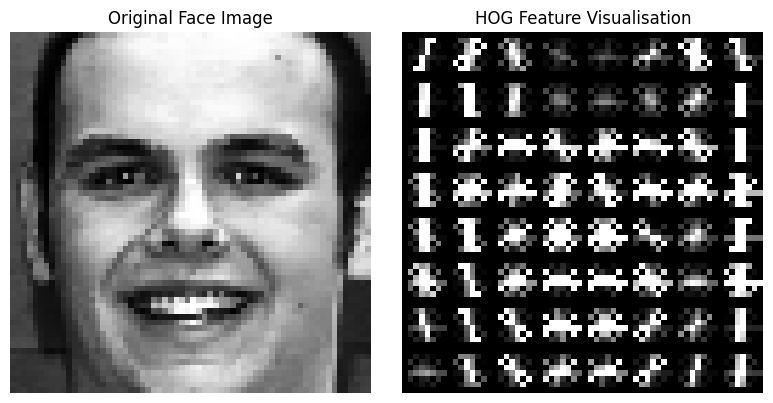

In [10]:
# Load one example face image
img = cv2.imread("CK/CK_dataset/test/happy/6.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (64, 64))

# Apply histogram equalisation (match training)
img = cv2.equalizeHist(img)

# Extract HOG with visualisation
hog_features, hog_image = hog(
    img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    visualize=True
)

# Improve visibility of HOG image
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot original vs HOG
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Face Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap="gray")
plt.title("HOG Feature Visualisation")
plt.axis("off")

plt.tight_layout()
plt.show()
